In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV 
import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, LSTM
from keras.layers import Dropout
from keras import backend as K

In [2]:
new_df = pd.read_csv("../data/new_df.csv")
new_df.drop(columns = 'Unnamed: 0', inplace=True)

In [3]:
#normalizing
scaler = StandardScaler()
new_df.iloc[:, 6:496] = scaler.fit_transform(new_df.iloc[:, 6:496])

## Density diagarams of the different variables per class

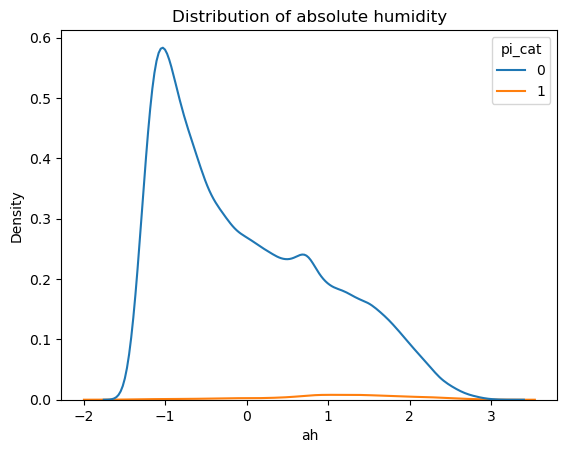

In [4]:
new_df.pi_cat = np.where(new_df.pi24>15,1,0)

sns.kdeplot(data=new_df, x= "ah", hue = "pi_cat").set(title='Distribution of absolute humidity')
plt.savefig('pics.png', dpi=300)

In [5]:
split_index = round(new_df.shape[0] * 0.8)

test = new_df[split_index:]
train = new_df[:split_index]

# KNN

In [6]:
%%time
# KNN
KNN = KNeighborsClassifier(n_neighbors=1, metric='cosine', n_jobs=-1)

KNN.fit(X = train.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]], y = train.loc[:, 'pi_cat'])


CPU times: total: 46.9 ms
Wall time: 56.4 ms


KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=1)

In [7]:
%%time
preds = KNN.predict(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]].values)

KNN_proba = KNN.predict_proba(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]].values)

c:\Users\rokka\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rokka\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


CPU times: total: 7min 40s
Wall time: 4min 16s


In [8]:
cm = confusion_matrix(test.loc[:, 'pi_cat'], preds)

[Text(0, 0.5, 'Not Extreme'), Text(0, 1.5, 'Extreme')]

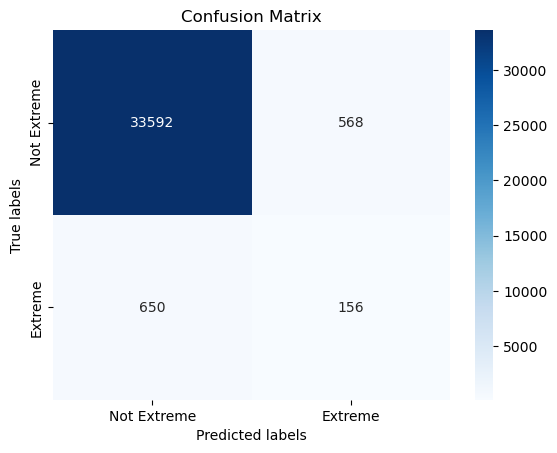

In [9]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')  
#annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Not Extreme", "Extreme"])
ax.yaxis.set_ticklabels(["Not Extreme", "Extreme"])

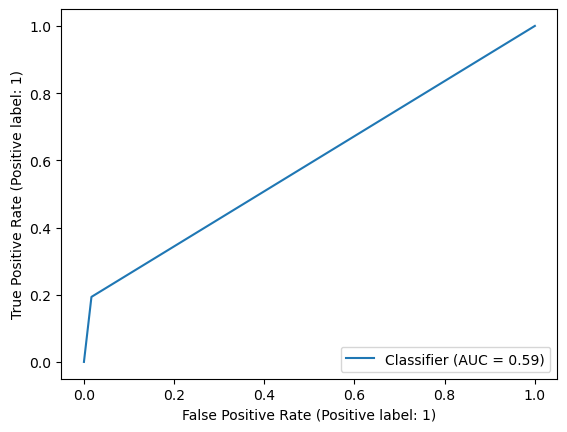

In [10]:
RocCurveDisplay.from_predictions(test.loc[:, 'pi_cat'], KNN_proba[:,1])
plt.show()

In [11]:
f1_score(test.loc[:, 'pi_cat'], preds)

0.203921568627451

In [12]:
accuracy_score(test.loc[:, 'pi_cat'], preds)

0.965166161413945

# Random Forest

In [13]:
RF = RandomForestClassifier(n_jobs= -1, class_weight=None)

RF.fit(X = train.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]], y = train.loc[:, 'pi_cat'])

RandomForestClassifier(n_jobs=-1)

In [14]:
RF.feature_importances_

array([0.03326863, 0.04419017, 0.02729784, 0.0402259 , 0.03800625,
       0.04929876, 0.07942517, 0.03080221, 0.041675  , 0.02700168,
       0.03706927, 0.03352995, 0.0382388 , 0.03105546, 0.02918452,
       0.03700955, 0.02705841, 0.03762049, 0.03219932, 0.03825882,
       0.01871352, 0.03138649, 0.03778904, 0.02816522, 0.03714624,
       0.03474946, 0.04282957, 0.01680424])

In [15]:
RF_preds = RF.predict(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])
RF_proba = RF.predict_proba(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])


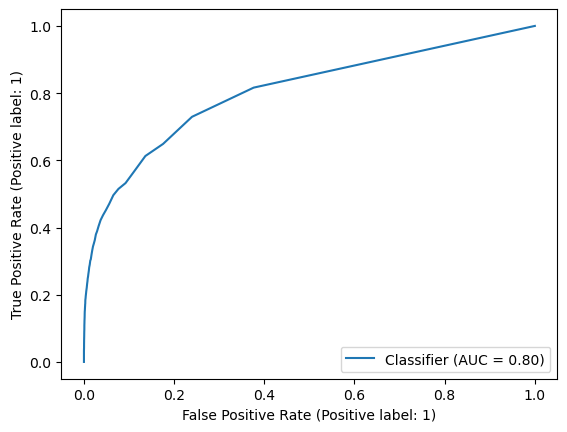

In [16]:
RocCurveDisplay.from_predictions(test.loc[:, 'pi_cat'], RF_proba[:,1])
plt.savefig('rf_roc.png', dpi=300)

In [17]:
rf_cm = confusion_matrix(test.loc[:, 'pi_cat'], RF_preds)

[Text(0, 0.5, 'Not Extreme'), Text(0, 1.5, 'Extreme')]

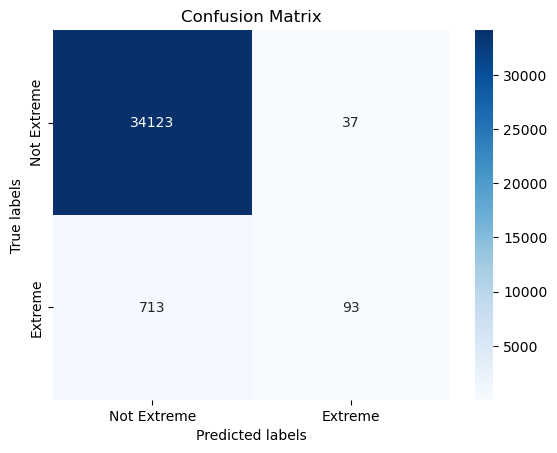

In [18]:
ax= plt.subplot()
sns.heatmap(rf_cm, annot=True, fmt='g', ax=ax, cmap='Blues')  
#annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Not Extreme", "Extreme"])
ax.yaxis.set_ticklabels(["Not Extreme", "Extreme"])

In [19]:
f1_score(test.loc[:, 'pi_cat'], RF_preds)
# accuracy_score(test.loc[:, 'pi_cat'], RF_preds)

0.1987179487179487

# LightGBM

In [20]:
parameters = {'boosting_type':['dart'], 
              'learning_rate':[.3,.4,.5, .6],
              'n_jobs': [-1],
              'class_weight': ['balanced']}

lgbmc = LGBMClassifier()

clf = GridSearchCV(lgbmc, 
                   parameters, 
                   scoring= 'f1',
                   n_jobs=-1)

lgbm_fit = clf.fit(X = train.iloc[:, 6:106], y = train.loc[:, 'pi_cat'])

[LightGBM] [Info] Number of positive: 2142, number of negative: 137723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23760
[LightGBM] [Info] Number of data points in the train set: 139865, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [21]:
pd.DataFrame(lgbm_fit.cv_results_)[['params','mean_test_score','rank_test_score']].sort_values('rank_test_score').head(10)

,params,mean_test_score,rank_test_score
1,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.239211,1
0,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.238548,2
2,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.235697,3
3,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.227160,4


In [22]:
lgbmc = LGBMClassifier(boosting_type='dart', learning_rate=.4, n_jobs=-1, class_weight='balanced')

lgbmc.fit(X = train.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]], y = train.loc[:, 'pi_cat'])

[LightGBM] [Info] Number of positive: 2142, number of negative: 137723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6444
[LightGBM] [Info] Number of data points in the train set: 139865, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(boosting_type='dart', class_weight='balanced', learning_rate=0.4,
               n_jobs=-1)

In [23]:
LG_preds = lgbmc.predict(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])

In [24]:
LG_proba = lgbmc.predict_proba(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])

In [25]:
lg_cm = confusion_matrix(test.loc[:, 'pi_cat'], LG_preds)

[Text(0, 0.5, 'Not Extreme'), Text(0, 1.5, 'Extreme')]

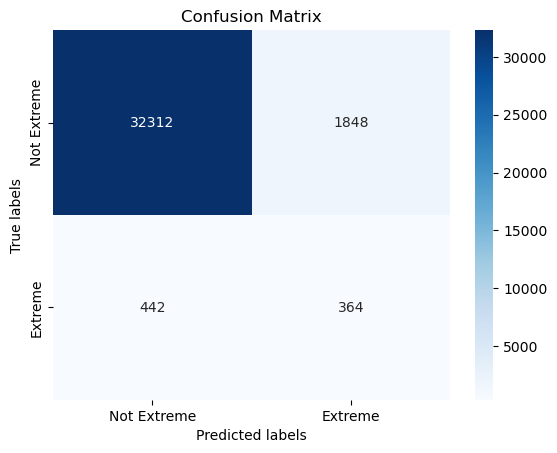

In [26]:
ax= plt.subplot()
sns.heatmap(lg_cm, annot=True, fmt='g', ax=ax, cmap='Blues')  
#annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Not Extreme", "Extreme"])
ax.yaxis.set_ticklabels(["Not Extreme", "Extreme"])

In [27]:
f1_score(test.loc[:, 'pi_cat'], LG_preds)

0.24121935056328692

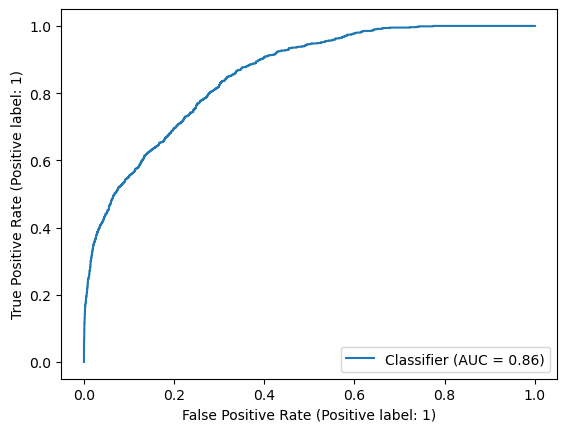

In [28]:
RocCurveDisplay.from_predictions(test.loc[:, 'pi_cat'], LG_proba[:,1])
plt.savefig('lgbm_roc.png', dpi=300)

# GRU

In [29]:
X = np.array(train.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]]).reshape(train.shape[0],-1, 7)
y = np.array(train['pi_cat'])

In [30]:
X_test = np.array(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]]).reshape(test.shape[0],-1,7)
y_test = np.array(test['pi_cat'])

In [31]:
class_weights = {0: 1., 1: 70.}
grumod = Sequential()

grumod.add(LSTM(units = 10, return_sequences = True, input_shape = (4, 7)))
grumod.add(Dropout(0.2))

grumod.add(LSTM(units = 3, return_sequences = False))
grumod.add(Dropout(0.2))

grumod.add(Dense(units = 1, activation='sigmoid'))

grumod.compile(optimizer = 'adam', loss = 'binary_crossentropy')

history = grumod.fit(X, train.pi_cat, validation_data=(X_test,test.pi_cat), epochs = 50, batch_size = 512, class_weight = class_weights)

Epoch 1/50
274/274 [==============================] - 13s 18ms/step - loss: 1.1163 - val_loss: 0.5340
Epoch 2/50
274/274 [==============================] - 4s 14ms/step - loss: 0.8784 - val_loss: 0.5248
Epoch 3/50
274/274 [==============================] - 4s 14ms/step - loss: 0.8348 - val_loss: 0.4927
Epoch 4/50
274/274 [==============================] - 4s 15ms/step - loss: 0.8058 - val_loss: 0.5189
Epoch 5/50
274/274 [==============================] - 4s 13ms/step - loss: 0.7985 - val_loss: 0.4922
Epoch 6/50
274/274 [==============================] - 4s 13ms/step - loss: 0.7839 - val_loss: 0.4797
Epoch 7/50
274/274 [==============================] - 4s 13ms/step - loss: 0.7665 - val_loss: 0.4949
Epoch 8/50
274/274 [==============================] - 4s 13ms/step - loss: 0.7619 - val_loss: 0.4725
Epoch 9/50
274/274 [==============================] - 4s 13ms/step - loss: 0.7528 - val_loss: 0.4505
Epoch 10/50
274/274 [==============================] - 4s 13ms/step - loss: 0.7367 - val_l

In [32]:
gru_preds = grumod.predict(X_test[:,:10,:])

1093/1093 [==============================] - 6s 3ms/step


In [33]:
gru_cm = confusion_matrix(test.pi_cat,np.round(gru_preds))

[Text(0, 0.5, 'Not Extreme'), Text(0, 1.5, 'Extreme')]

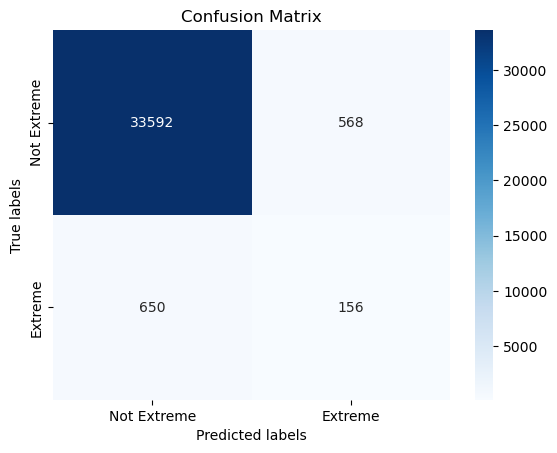

In [34]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')  
#annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Not Extreme", "Extreme"])
ax.yaxis.set_ticklabels(["Not Extreme", "Extreme"])

In [35]:
f1_score(test.pi_cat,np.round(gru_preds))

0.137451171875

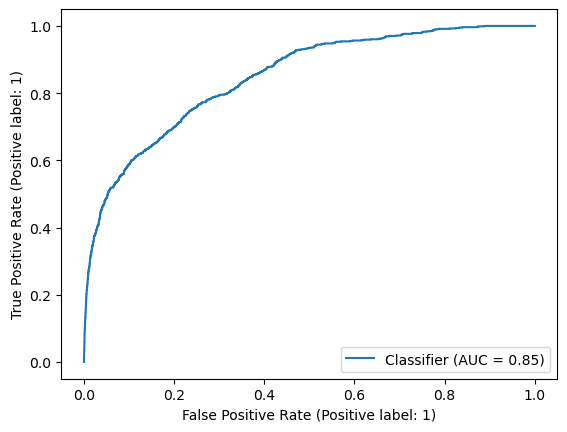

In [36]:
RocCurveDisplay.from_predictions(test.pi_cat,gru_preds)
plt.savefig('gru_roc.png', dpi=300)